# Algorithm to optimize phase mask

In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
% matplotlib inline

C:\Python34\lib\site-packages\IPython\kernel\__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


## Utilities

In [2]:
def myfft2(wave_in):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(wave_in)))

def myifft2(wave_in):
    return np.fft.ifftshift(np.fft.ifft2(np.fft.fftshift(wave_in)))

def cart2pol(x,y):
    """
    Takes cartesian (2D) coordinates and transforms them into polar.
    """
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return(rho, phi)

## Algorithm

In [3]:
def calcMask(EP, FPMinit, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak):
    """
    Calculates an optimized mask starting from a vortex, for a given entrance pupil EP
    :param EP: Entrance pupil given on a NxN grid axis 0,0
    :param FPMinit: initial focal plane mask
    :param LS: Lyot stop mask
    :param OPT_REG_FP:
    :param OPT_REG_LP:
    :param max_its: max number of iterations
    :goal_leak: fraction of leaked light desirable in the end
    """
    PSF = myfft2(EP) # field at focal plane
    FP = PSF*FPMinit # field just after initial focal plane mask
    
    count = 0  # counter for iterations
    leaks = []  #array to store leak at each iteration
    leak = 1 # intialize leak to 1
    maxleak = np.sum(np.sum(abs(EP*LS)**2))
    
    while(count < max_its and leak > goal_leak):
        count += 1
        LPj = myifft2(FP)  # field in Lyot plane
        LPj *= (1-OPT_REG_LP) # field in LP with nodal region set to zero
        FPj = myfft2(LPj) # current focal plane
        FPC = np.exp(1j*OPT_REG_FP*(np.angle(FPj) - np.angle(PSF) - np.angle(FPMinit)))
        
        leak = np.sum(np.sum(np.real(LPj*LS))**2)/maxleak
        FP = PSF*FPMinit*FPC  # current phase mask, updated focal plane
        leaks.append(leak)
        
    del FPj
    del LPj
    its = count  # final count
    FPM = np.exp(1j*(np.angle(FP)-np.angle(PSF)))
    FPC = np.exp(1j*(np.angle(FP)-np.angle(PSF) - np.angle(FPMinit)))
    finalleak = leak
    return FPM, FPC, its, finalleak
    
    
    

## Main

In [6]:
N = 1024
x = np.arange(-N/2, N/2)
y = np.arange(-N/2, N/2)
X, Y = np.meshgrid(x,y)
RHO, THETA = cart2pol(X,Y)

apRad = 250
lambdaOverD = N/apRad/2

C:\Users\Chronis\Documents\Ambizione Project\Master project\pyNodal\pupil_masks.py:80: RuntimeWarning: overflow encountered in power
  ANpupil = (np.exp(-(Rho/apRad)**1000) - np.exp(-(Rho/Rin)**200))


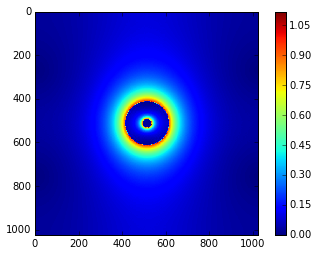

In [14]:
# choose entrance pupil 
#EP = fits.getdata('VLT_pupil_N=512_apRad_250.0.fits')
from pupil_masks import make_annular_pupil
EP = make_annular_pupil(1024, 100, 0.2)
#EP = np.lib.pad(EP, (256, 256), 'constant', constant_values=(0,0))
FPM_init = np.exp(1j*2*THETA)
FP = myfft2(EP)*FPM_init
LP = myifft2(FP)
plt.imshow(abs(LP), interpolation='nearest', cmap='jet')
plt.colorbar()

In [15]:
#EP = np.lib.pad(EP, (256, 256), 'constant', constant_values=(0,0))
normI = np.max(np.max(abs(myfft2(EP))**2))  # Irradiance normalization

charge = 2
FPM_init = np.exp(1j*charge*THETA)

OPT_REG_FP = np.ones((N,N))

LS = EP
OPT_REG_LP = EP

max_its = 50
goal_leak = 1e-6
FPM,FPC,its,leak = calcMask( EP, FPM_init, LS, OPT_REG_FP, OPT_REG_LP, max_its, goal_leak )


### Optimized Phase Mask (no circular symmetry imposed)

13 8.37161723009e-07


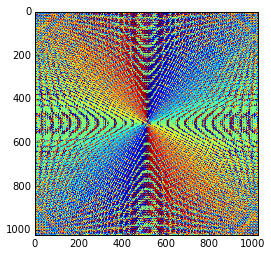

In [16]:
print(its, leak)
plt.imshow(np.angle(FPM))

### Lyot plane of the VLT pupil with Lyot stop and vortex phase mask 

17788360.2622


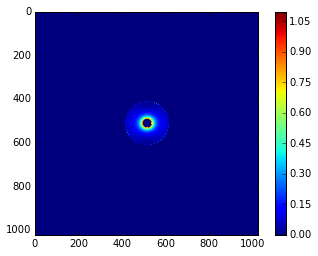

In [22]:
PSF = myfft2(EP)
FP = PSF*FPM_init
LPj = myifft2(FP)
LPj_stop = LPj*LS
plt.imshow(abs(LPj_stop))
plt.colorbar()
print(np.sum(np.sum(abs(LPj_stop))**2))

### PSF of vortex mask applied for the VLT pupil

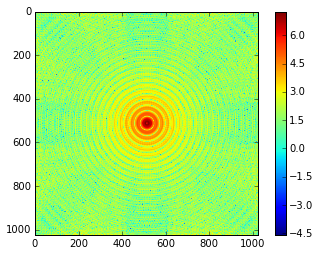

In [18]:
PSF2 = myfft2(LPj_stop)
plt.imshow(np.log(abs(PSF2)))
plt.colorbar()

### Lyot plane  of the VLT pupil with Lyot stop and optimized phase mask 

0.262404533634


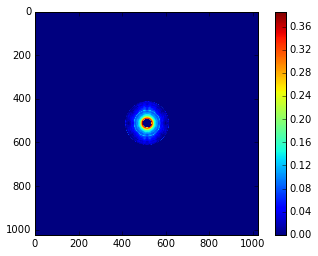

In [21]:
PSF_c = myfft2(EP)
FP_c = PSF_c*FPM
LPj_c = myifft2(FP_c)
LPj_stop_c = LPj_c*LS
plt.imshow(abs(LPj_stop_c))
plt.colorbar()
print(np.sum(np.sum(abs(LPj_stop_c))**2)/np.sum(np.sum(abs(LPj_stop))**2))

### PSF of the VLT pupil with the opt. mask

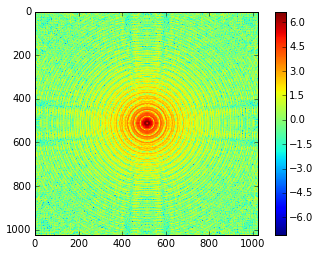

In [23]:
PSF2_c = myfft2(LPj_stop_c)
plt.imshow(np.log(abs(PSF2_c)))
plt.colorbar()